In [474]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re

In [475]:
land_df = pd.read_csv("daily_corona_data/aggregate_bundesland.csv", index_col=0)
land_df.Meldedatum = land_df.Meldedatum.transform(lambda x: datetime.datetime.strptime(re.sub("T.*", "", x), "%Y-%m-%d"))
land_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 0 to 278
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Meldedatum             293 non-null    datetime64[ns]
 1   Bundesland             293 non-null    object        
 2   AnzahlFall             293 non-null    int64         
 3   AnzahlTodesfall        293 non-null    int64         
 4   TotalAnzahlBundesland  293 non-null    int64         
 5   TotalDeathBundesland   293 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 16.0+ KB


In [476]:
datetime.datetime.strptime("2020-01-03", "%Y-%m-%d")

datetime.datetime(2020, 1, 3, 0, 0)

In [477]:
type(land_df.iloc[0, 0])

pandas._libs.tslibs.timestamps.Timestamp

In [478]:
lander = land_df.Bundesland.unique()
lander = [land for land in lander if land != "-nicht erhoben-"]

In [ ]:
tot_pops = {'Bayern': 13076721,
            'Schleswig-Holstein': 2896712,
            'Hamburg': 1841179,
            'Bremen': 82986,
            'Nordrhein-Westfalen': 17932651,
            'Hessen': 6265809,
            'Rheinland-Pfalz': 4084844,
            'Baden-Württemberg': 11069533,
            'Saarland': 990509,
            'Berlin': 3644826,
            'Mecklenburg-Vorpommern': 1609675,
            'Sachsen': 4077937,
            'Sachsen-Anhalt': 2208321,
            'Thüringen': 2143145,
           }

In [479]:
R0s = {"Bayern": 2.5, "Baden-Württemberg": 5, "Nordrhein-Westfalen": 4.8}

C:\Users\Alessandro\Documents\Projects\TeamUnicornVsCorona\env\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: Second argument 'r' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.


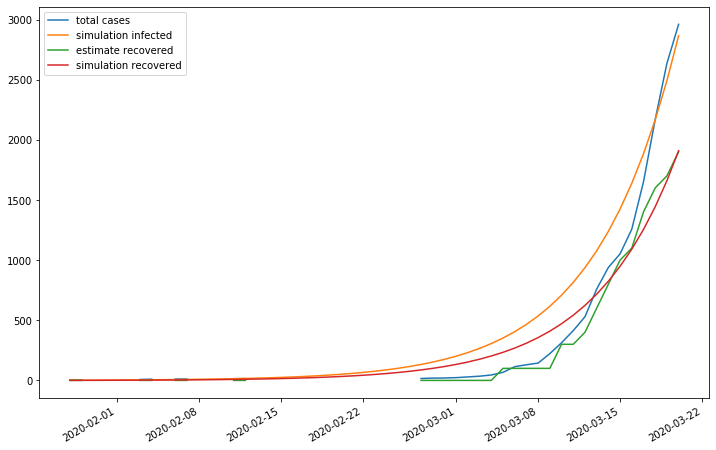

C:\Users\Alessandro\Documents\Projects\TeamUnicornVsCorona\env\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: Second argument 'r' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.


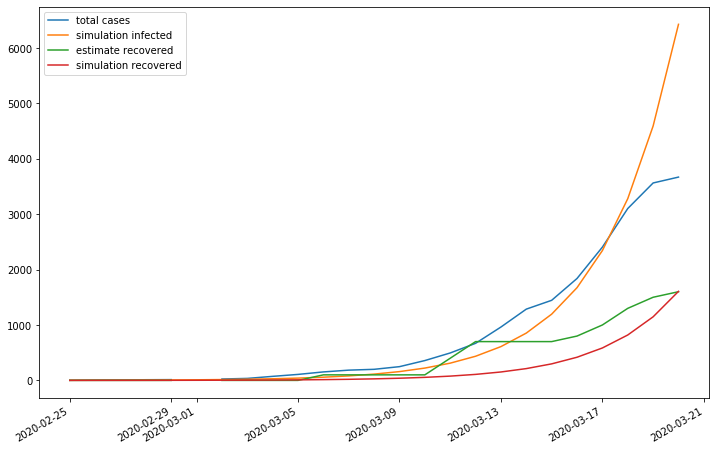

C:\Users\Alessandro\Documents\Projects\TeamUnicornVsCorona\env\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: Second argument 'r' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.


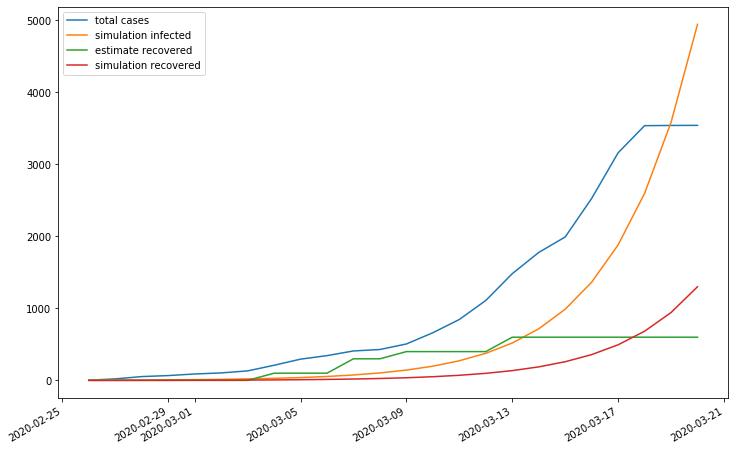

In [480]:
for land in ["Bayern", "Baden-Württemberg", "Nordrhein-Westfalen"]:
    temp_df = land_df[land_df.Bundesland == land]
    day_0 = temp_df.iloc[0].Meldedatum
    n_days =(temp_df.iloc[-1].Meldedatum - temp_df.iloc[0].Meldedatum).days + 1
    temp_df = temp_df.set_index("Meldedatum")
    tot_pop = tot_pops[land]

    i_0 = temp_df.loc[day_0, "TotalAnzahlBundesland"] / tot_pop
    s_0 = 1 - i_0 - r_0
    r_0 = temp_df.loc[day_0, "TotalDeathBundesland"] * 10 * 10 / tot_pop

    evol = [{"i": i_0, "r": r_0, "s": s_0}]

    R0 = R0s[land]
    g = 1 / 10
    b = R0 * g

    for day in range(1, n_days):
        s = evol[-1]["s"]
        r = evol[-1]["r"]
        i = evol[-1]["i"]
        new_s = s - b * i * s
        new_r = r + g * i
        new_i = i + b * i * s - g * i
        evol.append({"s": new_s, "r": new_r, "i": new_i})

    temp_df = temp_df.join(pd.DataFrame(evol, index=[day_0 + datetime.timedelta(days=j) for j in range(n_days)]) * tot_pop, how="outer")
    # Assume that 10% of the hospitalized die, and 10% of the sick are hospitalized
    temp_df["Recovered"] = temp_df.TotalDeathBundesland * 10 * 10

    fig = plt.figure(figsize=(12, 8))
    plt.title(f"{land}, R0 = {R0}")
    plt.plot(temp_df.index, 'TotalAnzahlBundesland', data=temp_df, label="total cases")
    plt.plot(temp_df.index, 'i', data=temp_df, label="simulation infected")
    plt.plot(temp_df.index, 'Recovered', data=temp_df, label="estimate recovered")
    plt.plot(temp_df.index, 'r', data=temp_df, label="simulation recovered")
    plt.legend()
    fig.autofmt_xdate()
    plt.show()

In [481]:
temp_df

,Bundesland,AnzahlFall,AnzahlTodesfall,TotalAnzahlBundesland,TotalDeathBundesland,i,r,s,Recovered
Meldedatum,,,,,,,,,
2020-02-26,Nordrhein-Westfalen,3,0,3,0,3.000000,0.000000,1.900000e+07,0
2020-02-27,Nordrhein-Westfalen,18,0,21,0,4.140000,0.300000,1.900000e+07,0
2020-02-28,Nordrhein-Westfalen,32,0,53,0,5.713199,0.714000,1.899999e+07,0
2020-02-29,Nordrhein-Westfalen,14,0,67,0,7.884214,1.285320,1.899999e+07,0
2020-03-01,Nordrhein-Westfalen,22,0,89,0,10.880213,2.073741,1.899999e+07,0
2020-03-02,Nordrhein-Westfalen,15,0,104,0,15.014691,3.161763,1.899998e+07,0
2020-03-03,Nordrhein-Westfalen,28,0,132,0,20.720267,4.663232,1.899997e+07,0
2020-03-04,Nordrhein-Westfalen,78,1,210,1,28.593955,6.735258,1.899996e+07,100
2020-03-05,Nordrhein-Westfalen,85,0,295,1,39.459632,9.594654,1.899995e+07,100


In [482]:
pd.DataFrame(evol, index=[day_0 + datetime.timedelta(days=j) for j in range(n_days)]) * tot_pop

,i,r,s
2020-02-26,3.000000,0.000000,1.900000e+07
2020-02-27,4.140000,0.300000,1.900000e+07
2020-02-28,5.713199,0.714000,1.899999e+07
2020-02-29,7.884214,1.285320,1.899999e+07
2020-03-01,10.880213,2.073741,1.899999e+07
2020-03-02,15.014691,3.161763,1.899998e+07
2020-03-03,20.720267,4.663232,1.899997e+07
2020-03-04,28.593955,6.735258,1.899996e+07
2020-03-05,39.459632,9.594654,1.899995e+07
2020-03-06,54.454243,13.540617,1.899993e+07
